<a href="https://colab.research.google.com/github/gouthamans14/Transformers_Notebooks/blob/main/Question_AnsweringUsingTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install transformers  datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00


### SQUAD


SQuAD, which stands for "Stanford Question Answering Dataset," is a widely used dataset in natural language processing (NLP) that is commonly used for training and evaluating question answering models.

The SQuAD dataset is often used as a benchmark for evaluating the performance of question answering models, including those based on transformer architectures

In [ ]:
from datasets import load_dataset


In [ ]:
raw_datasets = load_dataset("squad")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
raw_datasets['train'][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [ ]:
raw_datasets['train'].filter(lambda x: len(x['answers']['text'])!=1)

Filter:   0%|          | 0/87599 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

* Note: We have only one line answers in training datasets

In [ ]:
raw_datasets['validation'][1]["answers"]

{'text': ['Carolina Panthers', 'Carolina Panthers', 'Carolina Panthers'],
 'answer_start': [249, 249, 249]}

In [ ]:
raw_datasets["validation"].filter(lambda x: len(x['answers'])>1)

Filter:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 10570
})

* Note we have multiple answers in validation dataset

### Tokenizer

* Convert the text to numerical format

In [ ]:
from transformers import AutoTokenizer

* DistilBert Tokenizer can tokenize 2 sentences

In [ ]:
model_checkpoint ="distilbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

* This tokenizer can tokenize 2 pieces of text

In [ ]:
context = "I like eggs"
question ="What do I like?"

inputs = tokenizer(question, context)
inputs

{'input_ids': [101, 1327, 1202, 146, 1176, 136, 102, 146, 1176, 6471, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.decode(inputs["input_ids"])

'[CLS] What do I like? [SEP] I like eggs [SEP]'

Long Context:
* For QA, context can be very long
* BERT can only handle limited number of tokens
* We can't just truncate the context
* Solution: Split the context into multiple windows

Context Window 1 || Context Window2 || Context Window 3

* If half of the answer in the one context window and half of the answers in the next context window,
then no answers will be valid.

* So we will use overlaping window, this is called "Stride"

The stride parameter is typically associated with sequence classification tasks, and it determines how much the sliding window is shifted when breaking a long text into smaller segments during tokenization.

 If a text sequence is longer than max_length, it can be split into smaller segments using a sliding window approach, where the stride parameter would determine how much the window shifts for each segment.

In [32]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second", # we are letting tokenizer know to tokenize the context not the question
    stride=50,
    return_overflowing_tokens=True,
    return_offset_mapping=True
)

* return_overflowing_tokens=True - whether to return any overflowing tokens when tokenizing long sequences
*  When tokenizing a text sequence that is longer than the specified max_length, this parameter controls whether the extra tokens that do not fit within the maximum length should be returned or discarded.

In [33]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'overflow_to_sample_mapping'])

* This type of tokenizer expands the data.

* Overflow to sample Mapping - if we have one question and context pair we can have multiple input samples
depending on how long the sample is.
* Suppose inputs["overflow_to_sample_mapping"] is [0,0,0,1,1,2,3,3,3]
*this means that samople 0 got expanded into 3 parts inputs
* Sample 1 got expanded into 2 parts inputs
* sample 3 got expanded into 3 parts inputs
* Note: These integers are original input sample indices

In [36]:
inputs

{'input_ids': [[101, 1327, 1202, 146, 1176, 136, 102, 146, 1176, 6471, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'overflow_to_sample_mapping': [0]}

Offset_Mapping
* When tokenizing text, the input text is split into individual tokens (subwords) that are used for model input. The return_offset_mapping parameter allows you to obtain the starting and ending character offsets of each token in the original input text.
* Returns list of tuple, tuple will have start and end of the tokens

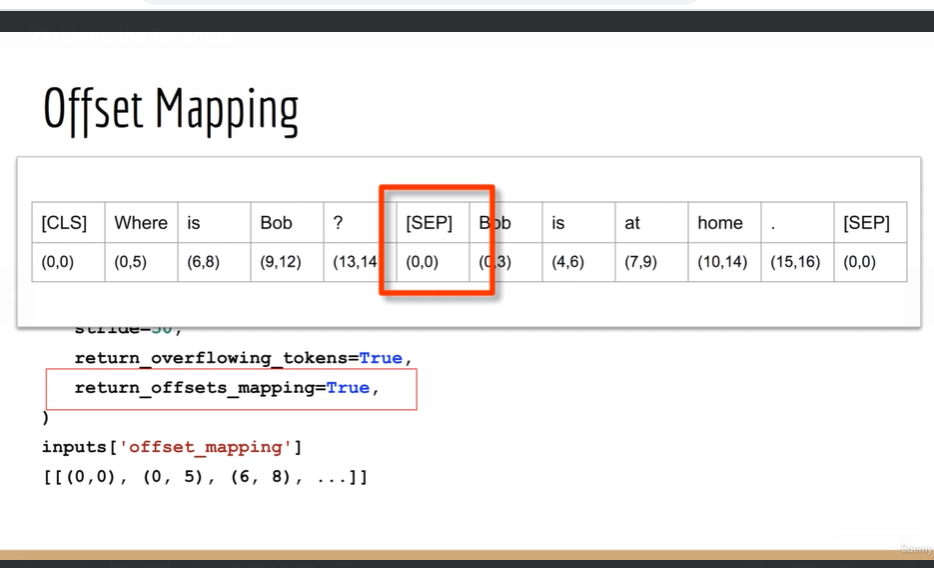